In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData, Integer, String, insert, select

import statsmodels.formula.api as smf

In [2]:
from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData, Integer, String, insert, select
from SQLalch_helpers import selectPlayerIDsSubQ
from SQLalch_helpers import selectSessionsDataScatter



engine = create_engine("sqlite+pysqlite:///GPSdata1.db", echo=False)

metadata_obj = MetaData()

players_table = Table("players", metadata_obj, autoload_with=engine)
sessions_data_table = Table("sessions_data", metadata_obj, autoload_with=engine)

In [3]:


# get player positions
positions = []

with engine.connect() as conn: 
    
    pos_stm = (
        select(players_table.c.position)
        .group_by(players_table.c.position)
    )

    positions = conn.execute(pos_stm).scalars().all() 

In [4]:
with engine.connect() as conn:
    select_stm_all_data = (
        select(sessions_data_table.c.Distance, sessions_data_table.c.HSR, players_table.c.position)
        .join(players_table, sessions_data_table.c.player_id == players_table.c.id)
    )

    result_all = conn.execute(select_stm_all_data)
    all_data = result_all.mappings().all()

all_df = pd.DataFrame(all_data)

In [5]:
all_df

,Distance,HSR,position
0,9516.8,282.8,CB
1,9579.7,465.3,CB
2,9167.9,249.9,CB
3,9826.8,385.1,CB
4,9756.8,440.9,CB
...,...,...,...
559,11572.3,863.8,FWD
560,10935.5,830.9,FWD
561,12110.2,1137.9,FWD
562,11278.4,810.2,FWD


In [6]:
model = smf.mixedlm("HSR ~ Distance",
                    all_df,
                    groups= "position").fit()


In [15]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   HSR       
No. Observations:   564       Method:               REML      
No. Groups:         4         Scale:                17139.1889
Min. group size:    98        Log-Likelihood:       -3556.8643
Max. group size:    185       Converged:            Yes       
Mean group size:    141.0                                     
--------------------------------------------------------------
               Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------
Intercept     -767.032   92.246 -8.315 0.000 -947.831 -586.233
Distance         0.130    0.007 18.357 0.000    0.116    0.143
position Var 12558.748   79.325                               
==============================================================

"""

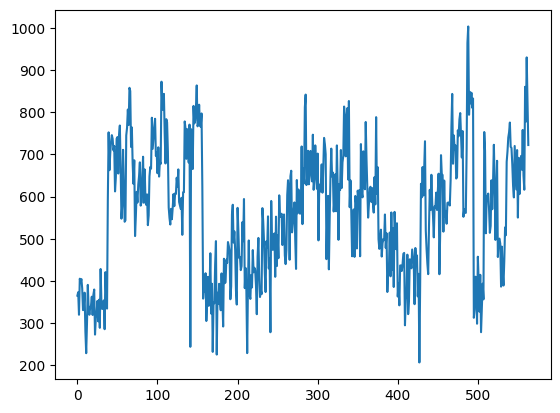

In [8]:
plt.plot(model.fittedvalues)

In [9]:
all_df["fitted"] = model.fittedvalues

In [10]:
all_df

,Distance,HSR,position,fitted
0,9516.8,282.8,CB,365.355352
1,9579.7,465.3,CB,373.505855
2,9167.9,249.9,CB,320.145329
3,9826.8,385.1,CB,405.524762
4,9756.8,440.9,CB,396.454250
...,...,...,...,...
559,11572.3,863.8,FWD,860.296399
560,10935.5,830.9,FWD,777.780655
561,12110.2,1137.9,FWD,929.996805
562,11278.4,810.2,FWD,822.213206


In [11]:
print(all_df["position"][0])

CB


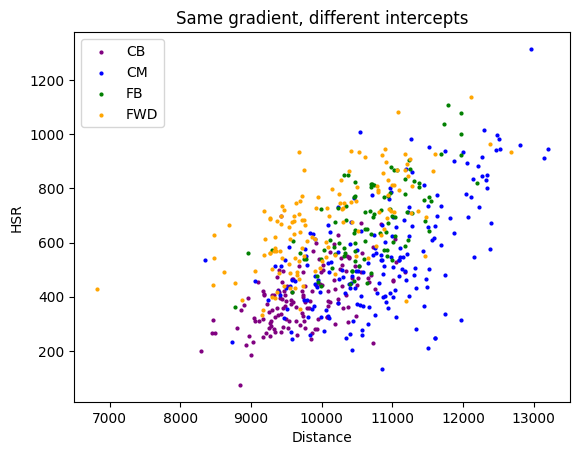

In [12]:
with engine.connect() as conn:
    select_stm_all_data = (
        select(sessions_data_table.c.Distance, sessions_data_table.c.HSR)
    )

    result_all = conn.execute(select_stm_all_data)
    all_data = result_all.mappings().all()

nall_df = pd.DataFrame(all_data)
x = nall_df["Distance"].values
y = nall_df["HSR"].values

colours = ["purple", "blue", "green", "orange"]

for i, position in enumerate(positions):
    pos_subQ = selectPlayerIDsSubQ(position, players_table)
    measure_columns = sessions_data_table.columns
    pos_data = selectSessionsDataScatter(pos_subQ, measure_columns, sessions_data_table)
    pos_df = pd.DataFrame(pos_data)
    x_axis = pos_df["Distance"]
    y_axis = pos_df["HSR"]

    if all_df["position"][i] == position:
        plt.plot(x_axis.values[i], all_df["fitted"][i])

    plt.scatter(x_axis, y_axis, color=colours[i], label = positions[i], s=4)
    

plt.legend()
plt.title("Same gradient, different intercepts")
plt.xlabel(x_axis.name)
plt.ylabel(y_axis.name)
plt.show()